# ISEL - CPS 
## Semestre 2020/21
# <br>
###  <center> Trabalho Prático </center>
# </br>
### aula 8

Trabalho realizado por:
* José Siopa, numero <b> 46338 </b>
* Pedro Ponte, numero <b> 46354 </b>

data: 24 de janeiro de 2021

A figura representa o esquema típico do processo de envio e recepção de informação usando modulações
digitais.

![fig_trab](esquemaCPS.png)

Este trabalho foca os blocos Modulação e desmodulação Digital.

Considere as funções já criadas em Python das aulas anteriores.

Construa uma função que simule a modulação digital 8-PSK.
Esta função recebe como parâmetro de entrada um array de bits e retorna um array, simulando o sinal analógico modulado a transmitir. Dado que o sinal modulado é simulado, é necessário que a função ainda receba como parâmetros de entrada o número de pontos por cada símbolo ($P=8$) e a energia média por bit ($E_b$). Admita que a frequência da portadora é tal que
cada simbolo contém um período da portadora.

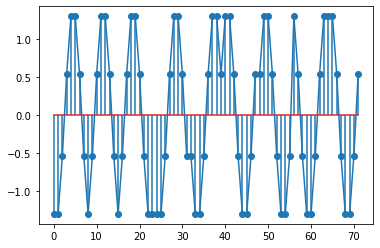

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from funcoes_criadas import *


def modulacao_MPSK(bits_in, P, Eb, Tb):
    # bits_in: mensagem de entrada
    # P: número pontos por cada símbolo
    # Eb: energia média por bit (Eb = 1/2 * Ar**2 * Tb)
    A = np.sqrt((2 * Eb) / Tb)

    # Fases
    # primeiro bit: 1 = +x,      0 = -x
    # segundo bit : 1 = +y,      0 = -y
    # terceiro bit: 1 = |tan|>1, 0 = |tan|<1
    fases = {
            '[1 1 0]':      np.pi / 8,
            '[1 1 1]':  3 * np.pi / 8,
            '[0 1 1]':  5 * np.pi / 8,
            '[0 1 0]':  7 * np.pi / 8,
            '[0 0 0]':  9 * np.pi / 8,
            '[0 0 1]': 11 * np.pi / 8,
            '[1 0 1]': 13 * np.pi / 8,
            '[1 0 0]': 15 * np.pi / 8
            }

    # numero de simbolos
    n = int(np.ceil(bits_in.size / 3.0))

    # pontos
    t = np.arange(P)

    # criação do sinal
    sinal = np.zeros(n * P).reshape(n, P)

    # zeros a acrescentar no fim para ficar no tamanho certo
    bit_stuffing = np.zeros(n * 3 - bits_in.size)

    # simbolos separados por linhas com bit stuffing
    simbolos = np.hstack((bits_in, bit_stuffing)).reshape(n, 3).astype(int)

    # cálculo do sinal
    for i in range(n):
        sinal[i] = A * np.cos(2 * np.pi * 1/P * t + fases[np.array2string(simbolos[i])])

    # colocar o sinal com o formato correto
    sinal_out = np.ravel(sinal)

    # adicionar header com a quantidade de bit stuffing
    fase_stuffing = np.array2string((Codific([bit_stuffing.size], 3)))
    sinal_stuffing = A * np.cos(2 * np.pi * 1/P * t + fases[fase_stuffing])
    sinal_out = np.hstack((sinal_stuffing, sinal_out))

    return sinal_out

bin_test = np.array([0,0,0,
                     0,0,1,
                     0,1,0,
                     0,1,1,
                     1,0,0,
                     1,0,1,
                     1,1,0,
                     1])

sinal_mod = modulacao_MPSK(bin_test, 8, 1, 1)
plt.plot(sinal_mod)
plt.stem(sinal_mod)
plt.show()

![fig_trab](8psk.png)

Depois de feita a função que realiza a moludação digital 8-PSK (phase shift keying), testámo-la com um array binário com diferentes combinações e também com um tamanho que não fosse múltiplo de 3, para testarmos a funcionalidade de bit stuffing. Por fim, conseguimos observar um plot do sinal modulado dividido em partes iguais onde cada parte tem uma fase diferente (correspondente à atribuida na constelação).

Construa uma função que simule, no receptor, um filtro adaptado (desmodulação).
Este deve receber um array com o sinal 8-PSK com ruído e deve retornar um array com a sequência binária correspondente.

In [2]:
def filtro_adaptado(sinal_in, P):
    # pontos
    t = np.arange(P)

    # numero de simbolos
    n = int(np.ceil(sinal_in.size / P))

    # separar o sinal em simbolos por linha
    sinal_in = sinal_in.reshape(n, P)

    # descobrir a região das constelação a que pertencem os pontos
    x = sinal_in[:] * (np.cos(2 * np.pi * 1/P * t))
    y = sinal_in[:] * (np.sin(2 * np.pi * 1/P * t))
    z = sinal_in[:] * np.cos(2 * np.pi * 1/P * t)

    # descobrir o sinal
    x = np.sign(np.sum(x, axis=1))
    y = -np.sign(np.sum(y, axis=1))
    z = np.abs(np.sum(z, axis=1))

    # transformar para binário
    x[x < 0] = 0
    y[y < 0] = 0
    z_ = np.zeros(z.size)
    z_[z < 11 * np.pi / 8] = 1

    # colocar na dimensão correta
    bin_out = np.ravel(np.vstack((x, y, z_)).T)

    # descodificar o header
    num_bit_stuff = int(Descodific(bin_out[:3], 3)[0])

    # remover o bit stuffing e retornar o sinal
    num_bit_stuff = bin_out.size if num_bit_stuff == 0 else num_bit_stuff

    return bin_out[3:bin_out.size - num_bit_stuff].astype(np.uint8)

filtro = filtro_adaptado(sinal_mod, 8)
print('Filtro:\n', filtro)
print('Resultado esperado:\n', bin_test)

Filtro:
 [0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 1 0 1 1 1 0 1]
Resultado esperado:
 [0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 1 0 1 1 1 0 1]


Nesta função, dividimos o sinal modulado em secções e, para cada secção, fomos calcular a região a que pertence na constelação para assim conseguirmos reconstruir (desmodular) a mensagem original (antes de ser modulada).

Construa uma função que simule um canal AWGN.
Esta função recebe o sinal modulado, adiciona ruído (com uma determinada potência $\sigma_n$)
e devolve o sinal com ruído num array.
A função deve ter como parâmetro de entrada a potência do ruído a adicionar

In [3]:
def canal_AWGN(sinal_in, pot_noise):
    return np.ravel(np.add(sinal_in, pot_noise * np.random.randn(1, len(sinal_in))))

Construa uma função que calcule o BER teórico para a modulação implementada.

In [4]:
def BER_teorico(P, Tb, W0):
    # P: número pontos por cada símbolo
    # Eb: energia média por bit (Eb = 1/2 * Ar**2 * Tb)
    # W0: portência por hertz do ruído no canal
    Eb = 1/2 * Tb
    k = np.log2(P)
    return 1 / k * special.erfc(np.sqrt(k * np.sin(np.pi / P)**2 * Eb / W0))

Avalie todo o sistema de emissão e receção. Para isso deve medir experimentalmente e comparar, sempre que possível, com os valores teóricos, os seguintes índices:

    A SNR no canal e SNR na recepção;
    
    BER antes e depois da correcção de erros;
    
    Apresente a constelação antes e depois do sinal passar pelo canal.

Para o efeito deve atribuir diferentes valores aos parâmetros do sistema e avalia-lo com e sem o modulo de correcção de erros.

Deve considerar que o sinal de entrada é a imagem fornecida no moodle, tendo em conta que é necessário transmitir um "Header" inicial com a informação necessária para o receptor construir a imagem.

In [7]:
from PIL import Image
from datetime import datetime

def lena(R, pot_erro, Eb, Tb, P, correcao):
    
    # ========== EMISSOR ===========


    lena_img = Image.open('lena_gray.tif')
    lena_arr = np.array(lena_img)

    vmax = np.max(lena_arr)

    ts_ini = datetime.timestamp(datetime.now())
    print('Time em segundos')

    # imagem quantificada
    Vq, Vd = quantific(R, vmax, 'midrise')
    lena_q, lena_iq = Quantificador(lena_arr, Vq, Vd)
    ts_now = datetime.timestamp(datetime.now())
    print('Time Quantificador:', np.round(ts_now - ts_ini, 4))

    # codificação dos indices
    codific = Codific(lena_iq, R)
    ts_now2 = datetime.timestamp(datetime.now())
    print('Time Codificador:', np.round(ts_now2 - ts_now, 4))

    # hamming (controlo de erros)
    lena_ham, n_zeros = Hamming_7_4(codific)
    ts_now3 = datetime.timestamp(datetime.now())
    print('Time Hamming:', np.round(ts_now3 - ts_now2, 4))

    # modulação 8-PSK
    lena_mod = modulacao_MPSK(lena_ham, P, Eb, Tb)
    ts_now4 = datetime.timestamp(datetime.now())
    print('Time Modulador:', np.round(ts_now4 - ts_now3, 4))


    # =========== CANAL ============


    # canal AWGN
    lena_canal = canal_AWGN(lena_mod, pot_erro)
    ts_now5 = datetime.timestamp(datetime.now())
    print('Time Canal AWGN:', np.round(ts_now5 - ts_now4, 4))


    # ========== RECETOR ===========


    # desmodulação (filtro adaptado)
    lena_filtrada = filtro_adaptado(lena_canal, P)
    ts_now6 = datetime.timestamp(datetime.now())
    print('Time Filtro Adaptado:', np.round(ts_now6 - ts_now5, 4))

    # detetor e corretor
    detetor = Detetor(lena_filtrada, n_zeros)
    ts_now7 = datetime.timestamp(datetime.now())
    print('Time Detetor e Corretor:', np.round(ts_now7 - ts_now6, 4))

    # descodificacao dos indices
    lena_iq_descodific = Descodific(detetor, R) if correcao else Descodific(lena_filtrada, R)
    
    # buscar os valores de quantificação
    lena_iq_descodific[lena_iq_descodific >= Vq.size] = 0
    lena_descodific = Vq[lena_iq_descodific]
    ts_now8 = datetime.timestamp(datetime.now())
    print('Time Descodificador:', np.round(ts_now8 - ts_now7, 4))

    # reconstrução da imagem no formato correto e guardar
    lena_descodific = lena_descodific.reshape(lena_arr.shape).astype(np.uint8)
    ts_now9 = datetime.timestamp(datetime.now())
    print('Time Reconstrução:', np.round(ts_now9 - ts_now8, 4))

    print('')
    ts_now10 = datetime.timestamp(datetime.now())
    print('Time Total:', np.round(ts_now10 - ts_ini, 4))

    # plot da imagem final
    plt.figure(figsize=(10,7))
    plt.imshow(lena_descodific, cmap='gray')
    plt.axis('off'); plt.show()

    # SNR no canal e na receção
    SNRt_canal = Measure_SNRt(R, vmax, lena_arr)
    SNRp_canal = Measure_SNRp(lena_mod, lena_canal)

    SNRp_recetor = Measure_SNRp(codific, detetor)

    # BER antes e depois da correção de erros
    BERt_antes = BER_teorico(P, Tb, pot_erro)
    BERp_antes = BER_pratico(lena_mod, lena_canal)

    BERp_depois = BER_pratico(codific, detetor)

    print()
    print('SNR teórica no canal:  ', SNRt_canal)
    print('SNR prática no canal:  ', SNRp_canal)
    print('SNR prática no recetor:', SNRp_recetor)
    print()
    print('BER teórico antes:             ', BERt_antes)
    print('BER prático antes da correção: ', BERp_antes)
    print('BER prático depois da correção:', BERp_depois)

    consteLENAcao(P, Eb, Tb, lena_mod, lena_canal)

In [8]:
def consteLENAcao(P, Eb, Tb, modulador, canal_AWGN):
    A = np.sqrt(2*Eb / Tb)

    t = np.linspace(0, 2 * np.pi, 1000)

    x = np.cos(t)
    y = np.sin(t)

    sinal_mod = np.copy(modulador) / A
    sinal_mod = np.split(sinal_mod, sinal_mod.size // P)
    Tb = np.arange(P)
    x_filtrado_mod = np.mean(sinal_mod * np.cos(2 * np.pi * Tb * 1/P), axis=1) * 2
    y_filtrado_mod = np.mean(sinal_mod * np.sin(2 * np.pi * Tb * 1/P), axis=1) * 2

    sinal_canal = np.copy(canal_AWGN) / A
    sinal_canal = np.split(sinal_canal, sinal_canal.size // P)
    Tb = np.arange(P)
    x_filtrado_canal = np.mean(sinal_canal * np.cos(2 * np.pi * Tb * 1/P), axis=1) * 2
    y_filtrado_canal = np.mean(sinal_canal * np.sin(2 * np.pi * Tb * 1/P), axis=1) * 2

    plt.figure(figsize=(9,9))
    plt.subplot(121)
    plt.title('Constelação antes do canal')
    plt.plot(x, y, '.')
    plt.plot(x_filtrado_mod, y_filtrado_mod, 'r.')
    plt.axis('scaled'); plt.grid()

    plt.subplot(122)
    plt.title('Constelação depois do canal')
    plt.plot(x, y, '.')
    plt.plot(x_filtrado_canal, y_filtrado_canal, 'r.')
    plt.axis('scaled')
    plt.grid(); plt.show()

Time em segundos
Time Quantificador: 0.1881
Time Codificador: 1.3213
Time Hamming: 1.7708
Time Modulador: 88.3282
Time Canal AWGN: 0.4755
Time Filtro Adaptado: 0.2327
Time Detetor e Corretor: 6.8409
Time Descodificador: 0.0137
Time Reconstrução: 0.0006

Time Total: 99.1721

SNR teórica no canal:   25.233531158260398
SNR prática no canal:   9.207966214530073
SNR prática no recetor: 14.891229089955022

BER teórico antes:              0.20709212868651275
BER prático antes da correção:  0.0
BER prático depois da correção: 1.37


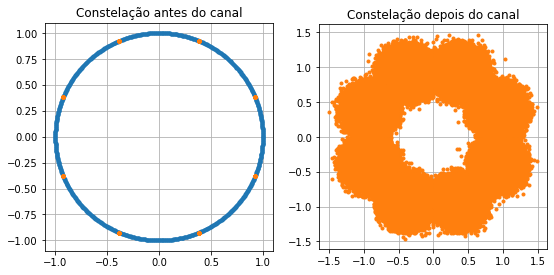

In [34]:
R = 8
P = 8
pot_erro = 0.6
Eb = 1
Tb = 1/3

lena(R, pot_erro, Eb, Tb, P, correcao=True)

Time em segundos
Time Quantificador: 0.0166
Time Codificador: 1.5732
Time Hamming: 1.5062
Time Modulador: 46.9097
Time Canal AWGN: 0.244
Time Filtro Adaptado: 0.1126
Time Detetor e Corretor: 5.7078
Time Descodificador: 0.0112
Time Reconstrução: 0.0009

Time Total: 56.0829

SNR teórica no canal:   1.2335311582603978
SNR prática no canal:   31.757187495786336
SNR prática no recetor: 5.243999814829601

BER teórico antes:              0.07540695106000794
BER prático antes da correção:  0.0
BER prático depois da correção: 10.33


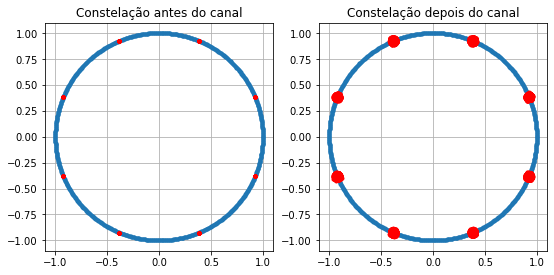

In [9]:
R = 4
P = 8
pot_erro = 0.1
Eb = 5
Tb = 1/3

lena(R, pot_erro, Eb, Tb, P, correcao=True)

Time em segundos
Time Quantificador: 0.1565
Time Codificador: 1.6756
Time Hamming: 2.804
Time Modulador: 89.2095
Time Canal AWGN: 0.4916
Time Filtro Adaptado: 0.2389
Time Detetor e Corretor: 3.3983
Time Descodificador: 0.0131
Time Reconstrução: 0.0008

Time Total: 97.9885

SNR teórica no canal:   25.233531158260398
SNR prática no canal:   24.77289021651192
SNR prática no recetor: 56.46866694137206

BER teórico antes:              0.07540695106000794
BER prático antes da correção:  0.0
BER prático depois da correção: 0.0


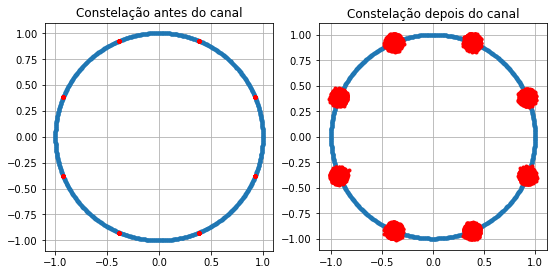

In [11]:
R = 8
P = 8
pot_erro = 0.1
Eb = 1
Tb = 1/3

lena(R, pot_erro, Eb, Tb, P, correcao=True)

Time em segundos
Time Quantificador: 0.1081
Time Codificador: 1.5776
Time Hamming: 2.4291
Time Modulador: 88.5884
Time Canal AWGN: 0.4918
Time Filtro Adaptado: 0.2448
Time Detetor e Corretor: 5.1808
Time Descodificador: 0.0138
Time Reconstrução: 0.0006

Time Total: 98.6353

SNR teórica no canal:   25.233531158260398
SNR prática no canal:   15.226270169506702
SNR prática no recetor: 20.296041770458316

BER teórico antes:              0.16158376995201357
BER prático antes da correção:  0.0
BER prático depois da correção: 0.4


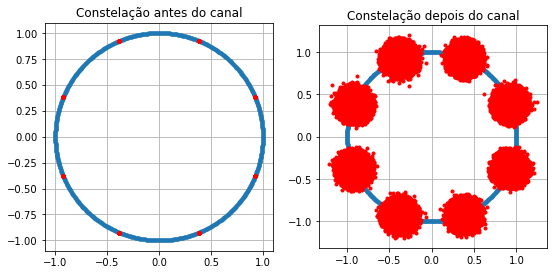

In [12]:
R = 8
P = 8
pot_erro = 0.3
Eb = 1
Tb = 1/3

lena(R, pot_erro, Eb, Tb, P, correcao=True)

Conclui-se pelos resultados acima que a potência do erro tem um limite de mais ou menos 0.5 até a constelação depois do canal ficar impercetível. A codificação da imagem a menos bits, apesar de apresentar uma boa constelação após o canal, tem vários erros visiveis no final. A redução do número de pontos por simbolo aumenta muito o tempo de modulação e introduz mais erros na imagem final.

Pelos valores obtidos no calculo da SNR e do BER observamos:
- Quantos mais bits usarmos para quantificar e codificar a imagem, menor será a quantidade de informação perdida e menor será a SNR.
- Quanto maior for a potência inserida no canal AWGN, maior será a quantidade de erros introduzidos e maior será o BER no receptor.